# Analysing the Musical Features of Popular Music in the United Kingdom between 2005 to 2022

## Data Preparation & Machine Learning Algorithms

### Sections

- [Data Preparation (must be completed before following sections)](#prep_data)
- [Checking for multicollinearity in data](#multicollinearity)
- [Investigation of musical feature distribution in Top 100 Chart songs](#feature_distribution)
- [Linear correlation of musical features and chart position](#feature_chart_correlation)
- [Linear correlation of musical features and chart position by individual year](#feature_chart_correlation_byyear)
- **Unsupervised Learning Algorithm**
    - [K-Means Clustering](#kmeans)
    - [Visualisation of K-Means clusters in two-dimentions using PCA](#kmeans_pca)
    - [K-Means Clustering of single year Top100 data](#kmeans_years)
- **Supervised Learning Algorithms**
    - [Generation of training and testing datasets (must be completed prior to supervised models)](#supervised_datsets)
    - [Random Forest Classifier model](#rf_model)
    - [Random Forest Classifier model - trained on 'Loudness' feature only](#rf_loudness)
    - [Support Vector Machine model - Linear kernel function](#svm)
    - [Support Vector Machine model - RBF kernel function](#svm_rbf)
    - [Support Vector Machine model - trained on 'Loudness' feature only](#svm_loudness)

In [32]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance   
from matplotlib import MatplotlibDeprecationWarning
from math import sqrt

<a id='prep_data'></a>
## Prepare datasets
- Using a Kaggle dataset of 600k songs' Spotify data - modified match the columns of our Top100 dataset and a 'Top100' column set to '-1'
- Remove any Top100 songs from the 600k datset
- Choose a random subset of 1700 from the 600k datset, to match the number of Top100 chart songs we have data for
- Combine our two datsets
- Scale the audio feature columns (for SVM, not RF) - ensure that test data is scaled using existing scaler parameters from training datsset
- Keep Year 2022 for testing (do not train using 2022 Top100 data)

In [33]:
#Import Top100 chart data
dfchart = pd.read_csv('chartspotifydata.csv', quotechar='|')
#Import Kaggle 600k non-chart dataset
df600k = pd.read_csv('600kspotify.csv', quotechar='|')  

# We remove any of our Top100 songs from the 600k set
df1 = dfchart[['Acousticness','Danceability','Energy','Instrumentalness','Liveness','Valence','Key','Mode','Tempo','Loudness']]
keys = list(df1.columns.values)
i1 = df600k.set_index(keys).index
i2 = df1.set_index(keys).index
dfnonchart600k = df600k[~i1.isin(i2)]

#Take a random sample of 1800 nonchart songs
#Split into training set (same size as Top100 dataset minus the single test year)
#and a test set of 100 songs
dfnonchart1800 = dfnonchart600k.sample(n=1800, random_state=123)
dfnonchart = dfnonchart1800.sample(n=1700, random_state=123)
dfnonchart100 = dfnonchart1800.drop(dfnonchart.index)

In [34]:
#Create a copy of chart data with duplicates removed
dedupe = dfchart.copy()

# Find chart entries that are duplicated across years and only retain the first appearance
# This may help later when training ML algorithms
duplicates = dedupe.duplicated(subset=['Artist', 'Track'], keep='first')
duplicates = pd.Series(duplicates)
duplicates = duplicates[duplicates == True]
for i in range(0, len(duplicates)):
    dedupe.drop(duplicates.index[i], inplace = True)

<a id='multicollinearity'></a>
### Checking for multicollinearity in Top100 Chart data
"Prior to any model creation it is good practice to check for multicollinearity, which is correlation between the independent features within the dataset." (https://towardsdatascience.com/spotify-genre-classification-algorithm-88051db23d42)

Only loudness and energy appear to correlate highly which is understandable.

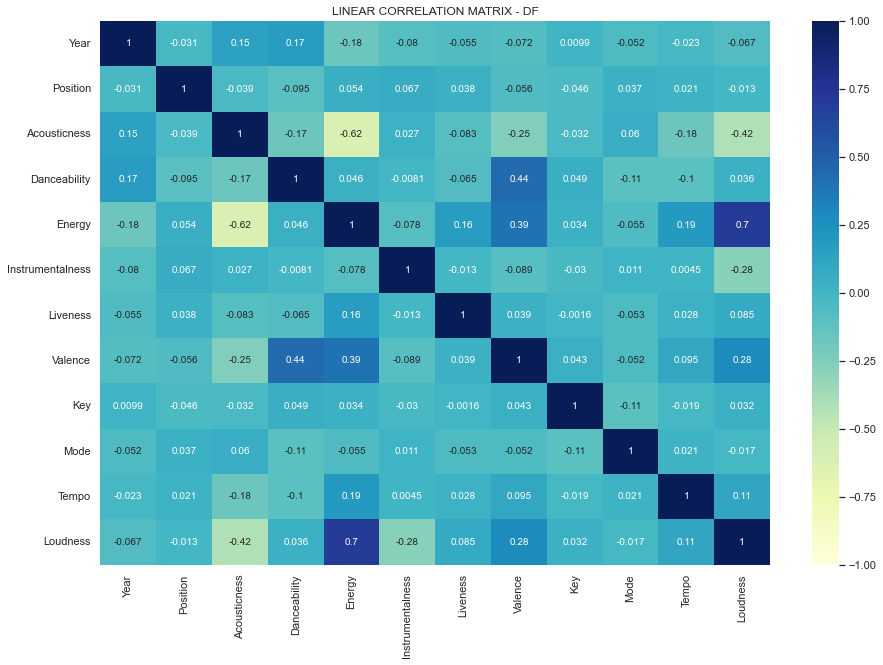

In [35]:
data = dedupe.copy()

data.drop(['Yeargroup'], axis = 1, inplace=True) #chart years are grouped
data.drop(['Positiongroup'], axis = 1, inplace=True) #grouped position
data.drop(['Top100'], axis = 1, inplace=True) #grouped position

# Plot linear correlation matrix
# https://towardsdatascience.com/spotify-genre-classification-algorithm-88051db23d42
%matplotlib inline 

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('LINEAR CORRELATION MATRIX - DF')
plt.show()

<a id='feature_distribution'></a>
### Investigation of musical feature distribution in Top 100 Chart songs

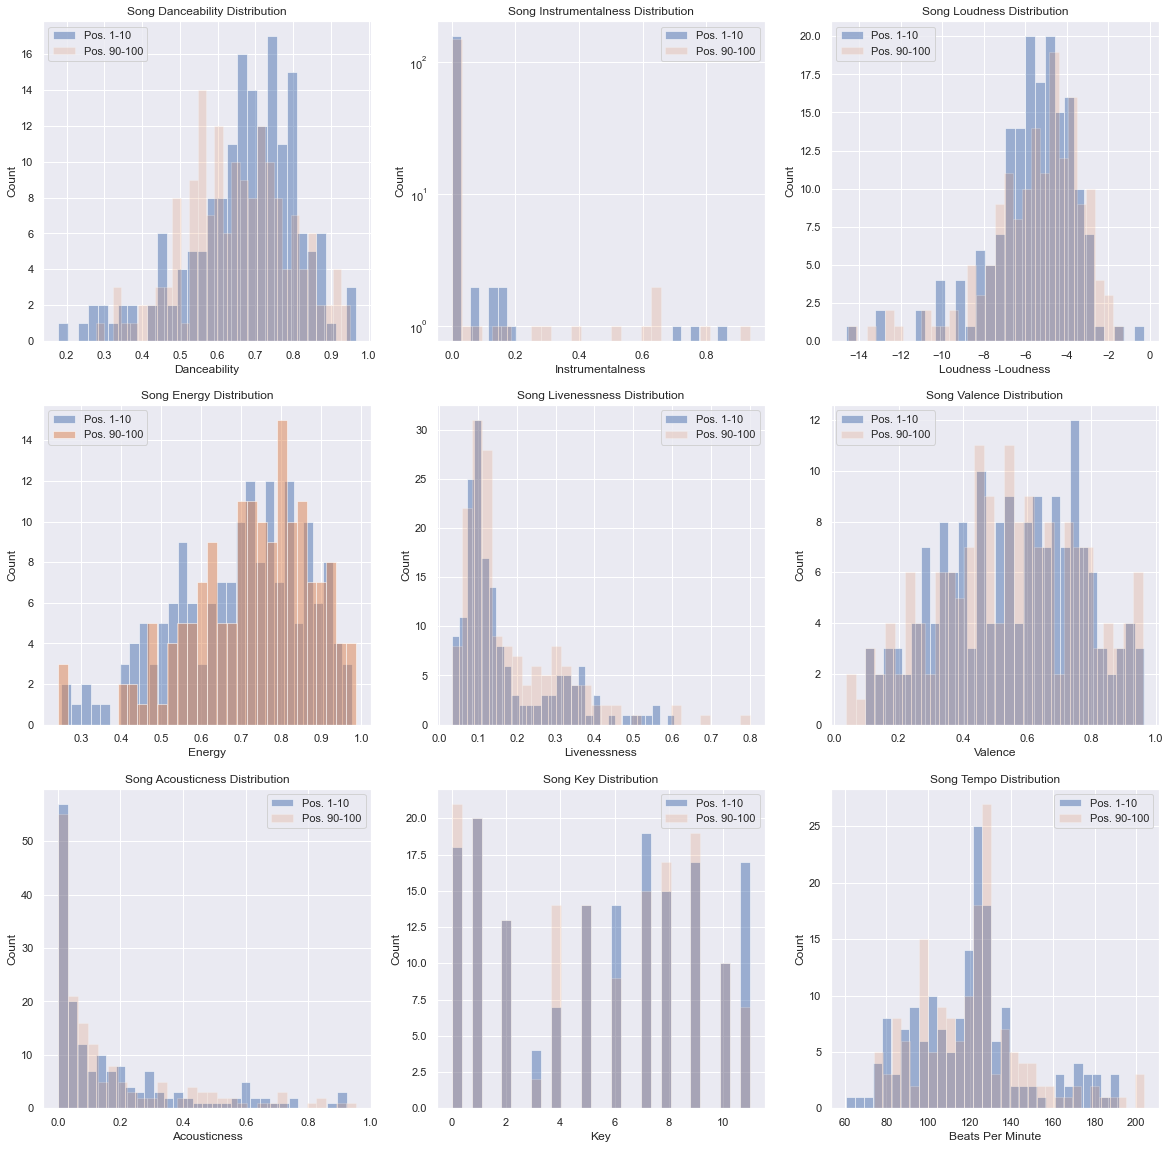

In [37]:
#Create a copy of the Top100 dataset
data = dedupe.copy()

# Code used from https://towardsdatascience.com/spotify-genre-classification-algorithm-88051db23d42

# for all features
pos_Tempo = data[data['Position'] <=10]['Tempo']
neg_Tempo = data[data['Position'] >=90]['Tempo']
pos_Energy = data[data['Position'] <=10]['Energy']
neg_Energy = data[data['Position'] >=90]['Energy']
pos_Loudness = data[data['Position'] <=10]['Loudness']
neg_Loudness = data[data['Position'] >=90]['Loudness']
pos_Liveness = data[data['Position'] <=10]['Liveness']
neg_Liveness = data[data['Position'] >=90]['Liveness']
pos_Instrumentalness = data[data['Position'] <=10]['Instrumentalness']
neg_Instrumentalness = data[data['Position'] >=90]['Instrumentalness']
pos_Acousticness = data[data['Position'] <=10]['Acousticness']
neg_Acousticness = data[data['Position'] >=90]['Acousticness']
pos_Key = data[data['Position'] <=10]['Key']
neg_Key = data[data['Position'] >=90]['Key']
pos_Valence = data[data['Position']<=10]['Valence']
neg_Valence = data[data['Position'] >=90]['Valence']
pos_Danceability = data[data['Position'] <=10]['Danceability']
neg_Danceability = data[data['Position'] >=90]['Danceability']

fig2 = plt.figure(figsize=(20,20))

#Danceability
ax3 = fig2.add_subplot(331)
ax3.set_xlabel('Danceability')
ax3.set_ylabel('Count')
ax3.set_title('Song Danceability Distribution')
pos_Danceability.hist(alpha=0.5, bins=30)
neg_Danceability.hist(alpha=0.2, bins=30)
plt.legend(['Pos. 1-10', 'Pos. 90-100'])

#Instrumentalnessation
ax5 = fig2.add_subplot(332)
ax5.set_xlabel('Instrumentalness')
ax5.set_ylabel('Count')
ax5.set_title('Song Instrumentalness Distribution')
plt.yscale('log')
pos_Instrumentalness.hist(alpha=0.5, bins=30)

neg_Instrumentalness.hist(alpha=0.2, bins=30)
plt.legend(['Pos. 1-10', 'Pos. 90-100'])

# loudness (Loudness)
ax7 = fig2.add_subplot(333)
ax7.set_xlabel('Loudness -Loudness')
ax7.set_ylabel('Count')
ax7.set_title('Song Loudness Distribution')
plt.legend(['Top40', 'Bottom60'])
pos_Loudness.hist(alpha=0.5, bins=30)
neg_Loudness.hist(alpha=0.2, bins=30)
plt.legend(['Pos. 1-10', 'Pos. 90-100'])

# energy
ax9 = fig2.add_subplot(334)
ax9.set_xlabel('Energy')
ax9.set_ylabel('Count')
ax9.set_title('Song Energy Distribution')
pos_Energy.hist(alpha=0.5, bins=30)
neg_Energy.hist(alpha=0.5, bins=30)
plt.legend(['Pos. 1-10', 'Pos. 90-100'])

# Liveness
ax10 = fig2.add_subplot(335)
ax10.set_xlabel('Livenessness')
ax10.set_ylabel('Count')
ax10.set_title('Song Livenessness Distribution')
pos_Liveness.hist(alpha=0.5, bins=30)
neg_Liveness.hist(alpha=0.2, bins=30)
plt.legend(['Pos. 1-10', 'Pos. 90-100'])

# val
ax12 = fig2.add_subplot(336)
ax12.set_xlabel('Valence')
ax12.set_ylabel('Count')
ax12.set_title('Song Valence Distribution')
pos_Valence.hist(alpha=0.5, bins=30)
#ax13 = fig2.add_subplot(336)
neg_Valence.hist(alpha=0.2, bins=30)
plt.legend(['Pos. 1-10', 'Pos. 90-100'])

# Acousticness
ax14 = fig2.add_subplot(337)
ax14.set_xlabel('Acousticness')
ax14.set_ylabel('Count')
ax14.set_title('Song Acousticness Distribution')
pos_Acousticness.hist(alpha=0.5, bins=30)
neg_Acousticness.hist(alpha=0.2, bins=30)
plt.legend(['Pos. 1-10', 'Pos. 90-100'])

# Key
ax16 = fig2.add_subplot(338)
ax16.set_xlabel('Key')
ax16.set_ylabel('Count')
ax16.set_title('Song Key Distribution')
pos_Key.hist(alpha=0.5, bins=30)
neg_Key.hist(alpha=0.2, bins=30)
plt.legend(['Pos. 1-10', 'Pos. 90-100'])

# Tempo
ax18 = fig2.add_subplot(339)
ax18.set_xlabel('Beats Per Minute')
ax18.set_ylabel('Count')
ax18.set_title('Song Tempo Distribution')
pos_Tempo.hist(alpha=0.5, bins=30)
neg_Tempo.hist(alpha=0.2, bins=30)
plt.legend(['Pos. 1-10', 'Pos. 90-100'])


<a id='feature_chart_correlation'></a>
### Linear correlation of musical features and chart position
Code adapted from https://dorazaria.github.io/machinelearning/spotify-popularity-prediction/

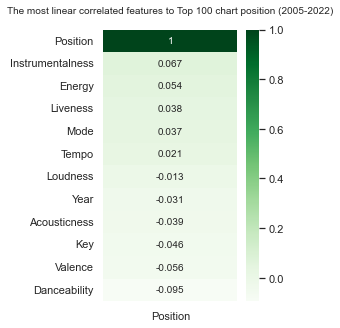

In [38]:
data = dedupe.copy()

data.drop(['Yeargroup'], axis = 1, inplace=True) #chart years are grouped
data.drop(['Positiongroup'], axis = 1, inplace=True) #grouped position
data.drop(['Track'], axis = 1, inplace=True)
data.drop(['Artist'], axis = 1, inplace=True)
data.drop(['Top100'], axis = 1, inplace=True)

corr = data.corr()[['Position']].sort_values(by='Position', ascending=False)
plt.figure(figsize=(3, 5))
heatmap = sns.heatmap(corr, annot=True, cmap='Greens')
heatmap.set_title('The most linear correlated features to Top 100 chart position (2005-2022)', 
                  fontdict={'fontsize':10}, pad=16);

<a id='feature_chart_correlation_byyear'></a>
### Linear correlation of musical features and chart position by individual year

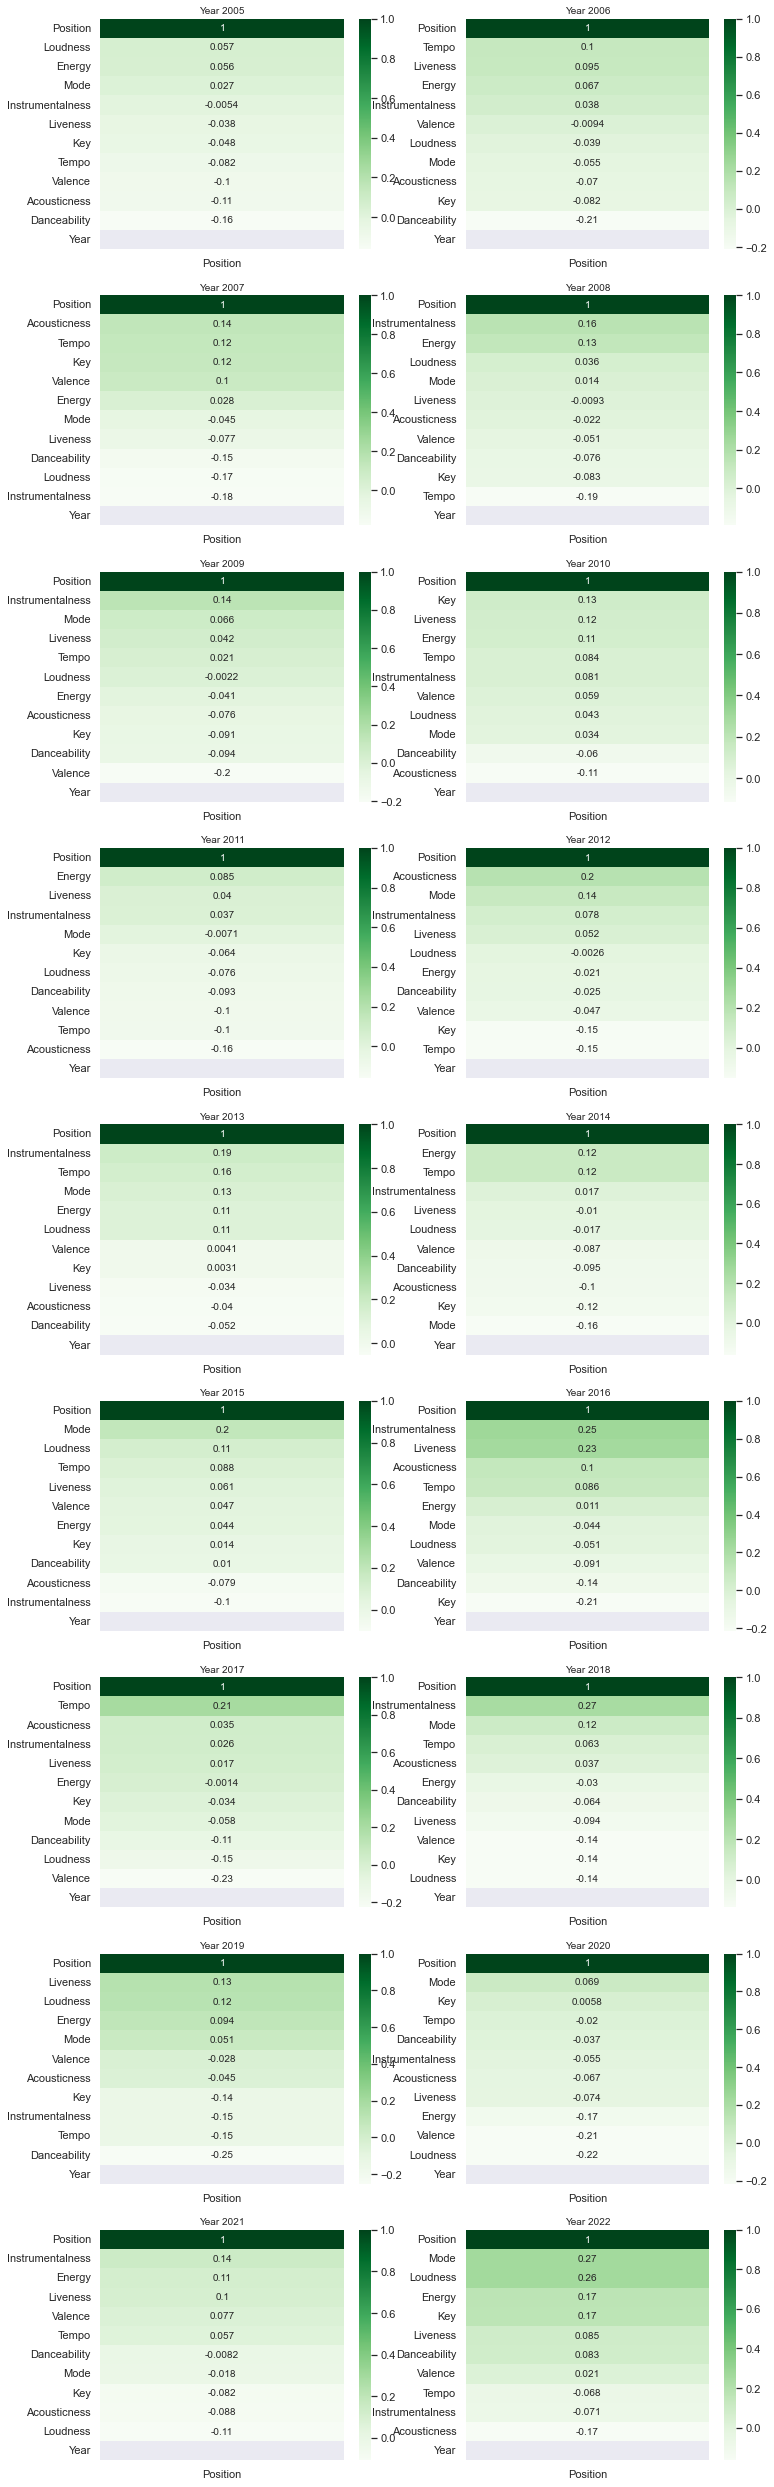

In [39]:
plt.figure(figsize=(12,50))

for f in range(0,18):
    plt.subplot(10,2,f+1)
    corr_df1 = data[data['Year'] == 2005+f]
    corr = corr_df1.corr()[['Position']].sort_values(by='Position', ascending=False)
    heatmap = sns.heatmap(corr, annot=True, cmap='Greens')
    title = "Year " + str(2005+f)
    heatmap.set_title(title, fontdict={'fontsize':10}, pad=5);

<a id='kmeans'></a>
## Unsupervised Learning Algorithm - K-Means Clustering

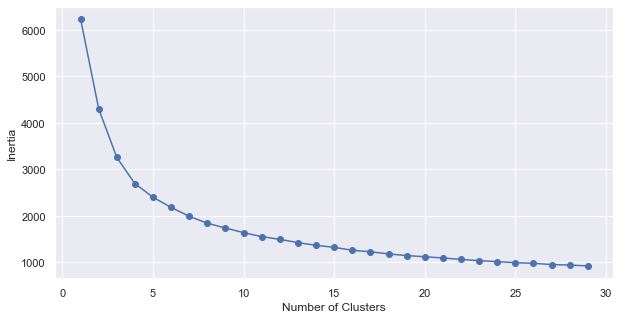

In [40]:
#Ignore memory warning
import warnings
warnings.filterwarnings('ignore')

# Create a fresh copy of our dataset to work with
dfkmeans = dedupe.copy() #Will retain all columns and add kmeans
data = dedupe.copy() #Will be used for training - drop non-required columns etc

## We remove any data that we will we do not want to use in training the algorithm (including the target column)
data.drop(["Year"], axis = 1, inplace=True) #the chart year
data.drop(['Yeargroup'], axis = 1, inplace=True) #chart years are grouped
data.drop(['Position'], axis = 1, inplace=True)  #actual position
data.drop(['Positiongroup'], axis = 1, inplace=True) #grouped position
data.drop(['Track'], axis = 1, inplace=True)
data.drop(['Artist'], axis = 1, inplace=True)
data.drop(['Top100'], axis = 1, inplace=True)

#Standardise the data
from sklearn.preprocessing import StandardScaler
column_names = data.columns
scaler = StandardScaler().fit(data)
data = scaler.transform(data)
data  = pd.DataFrame(data, columns=column_names)

#Determining the optimal number of clusters
def optimise_kmeans(data, max_k):
    means = []
    inertias = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    #Generate the elbow plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()
    
#Choosing to use 'Acousticness','Danceability','Energy','Valence' features
optimise_kmeans(data[['Acousticness','Danceability','Energy','Valence']],30)

In [42]:
#Train the K-Means Model
training_data = data[['Acousticness','Danceability','Energy','Valence']]

#Using 5 clusters (from elbow graph above)
kmeans = KMeans(n_clusters = 5, init='k-means++', max_iter=500, n_init=10, random_state=5)

#Do training
kmeans.fit(training_data)

KMeans(max_iter=500, n_clusters=5, random_state=5)

In [43]:
# Create a new dataframe to which we can add a column to show the K-Means cluster that each song is assigned to
# (We use a copy of our original data_so that it still contains all of the additional song info)
column_names = dfkmeans.columns
data_kmeans  = pd.DataFrame(dfkmeans, columns=column_names)

data_kmeans['KMeans'] = kmeans.labels_

#data_kmeans

In [51]:
# We can save this as a csv for further investigation
data_kmeans.to_csv('kmeans_output.csv')

<a id='kmeans_pca'></a>
### Visualisation of K-Means clusters in two-dimentions using PCA

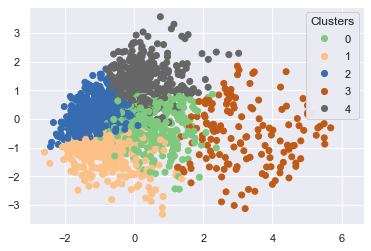

In [45]:
kmeans_labels = kmeans.labels_
X_PCA = PCA(2).fit_transform(training_data)

fig, ax = plt.subplots()

scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=kmeans_labels,cmap = plt.cm.get_cmap('Accent'))
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Clusters")
ax.add_artist(legend1)

<a id='kmeans_years'></a>
### K-Means Clustering of single year Top100 data

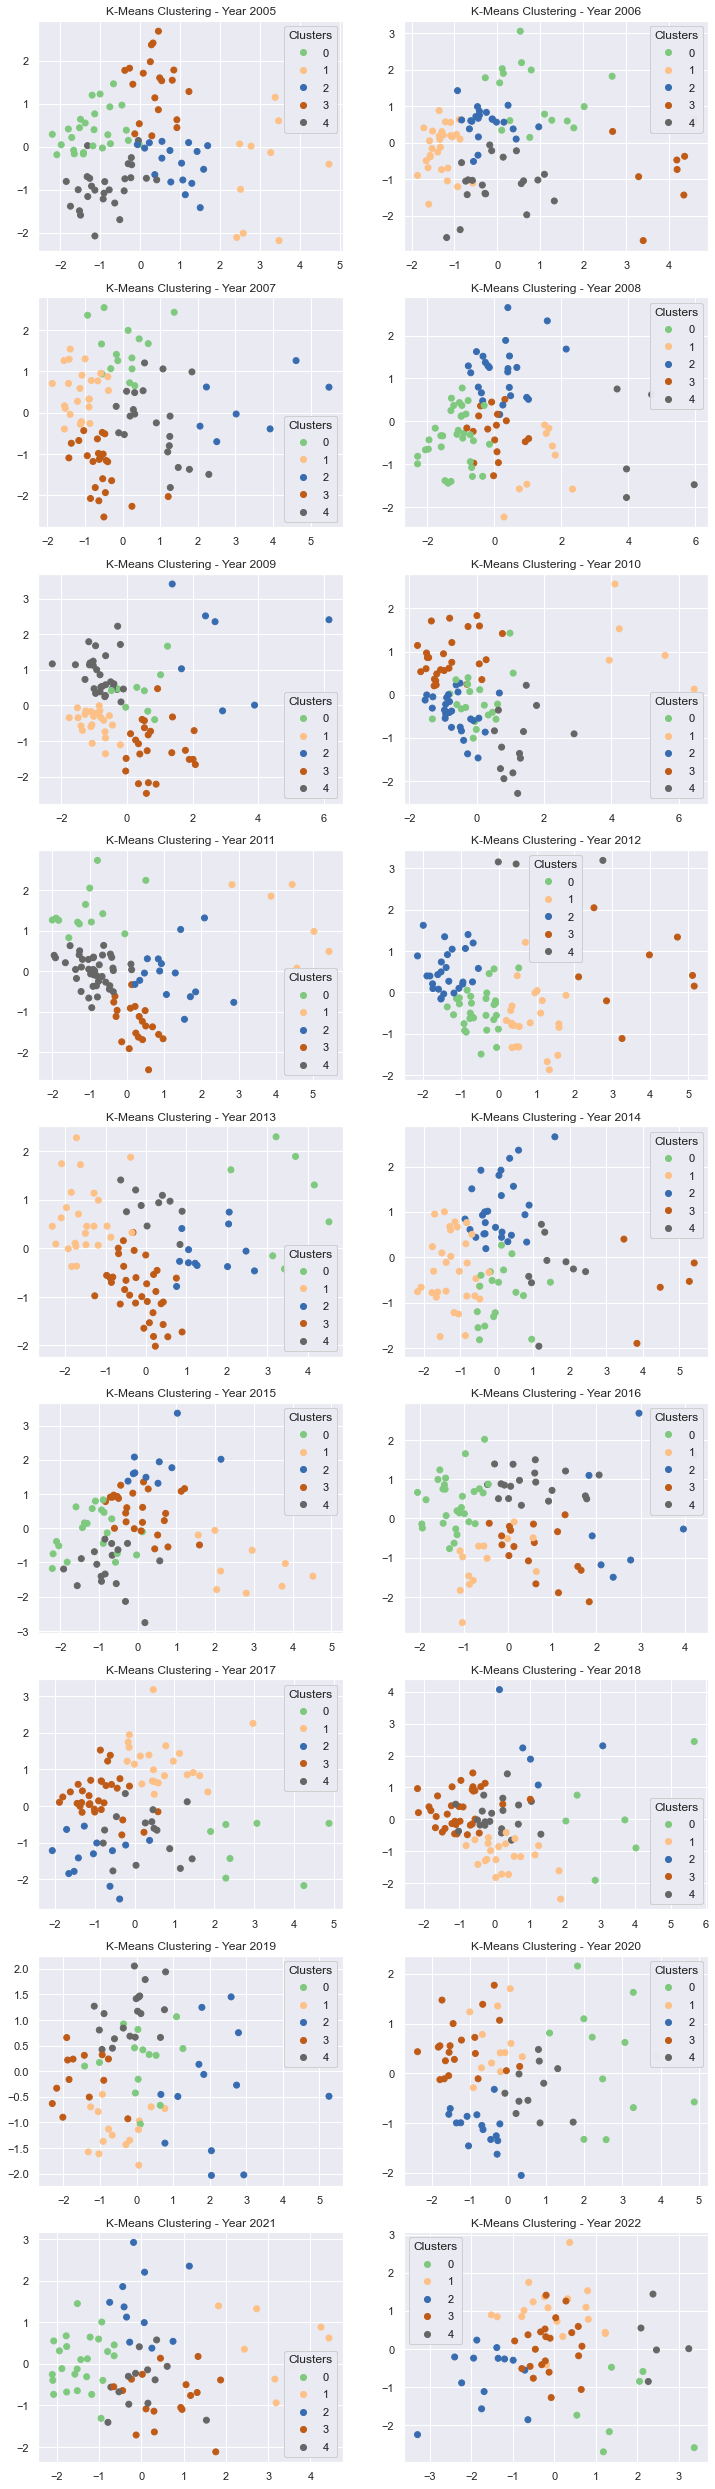

In [52]:
plt.figure(figsize=(12,50))

for i in range(0, 18):
    year = 2005+i
    # Create a fresh copy of our dataset to work with
    data_year = dedupe.copy()
    data_year = data_year[data_year['Year'] == year]
    data_yearx = data_year.copy()

    ## We remove any data that we will we do not want to use in training the algorithm (including the target column)
    data_yearx.drop(["Year"], axis = 1, inplace=True) #the chart year
    data_yearx.drop(['Yeargroup'], axis = 1, inplace=True) #chart years are grouped
    data_yearx.drop(['Position'], axis = 1, inplace=True)  #actual position
    data_yearx.drop(['Positiongroup'], axis = 1, inplace=True) #grouped position
    data_yearx.drop(['Track'], axis = 1, inplace=True)
    data_yearx.drop(['Artist'], axis = 1, inplace=True)
    data_yearx.drop(['Top100'], axis = 1, inplace=True) 

    #Standardise our data
    #This method seems more commonly used
    from sklearn.preprocessing import StandardScaler
    column_names = data_yearx.columns
    scaler = StandardScaler().fit(data_yearx)
    data_yearx = scaler.transform(data_yearx)
    data_yearx  = pd.DataFrame(data_yearx, columns=column_names)
    
    dfb = data_yearx.copy()  #Make sure we have all of our standardised data to save to CSV
    
    # Drop columns that we will not use in training
    data_yearx.drop(['Mode'], axis = 1, inplace=True)
    data_yearx.drop(['Instrumentalness'], axis = 1, inplace=True)
    data_yearx.drop(['Liveness'], axis = 1, inplace=True)
    data_yearx.drop(['Key'], axis = 1, inplace=True)
    data_yearx.drop(['Tempo'], axis = 1, inplace=True)
    data_yearx.drop(['Loudness'], axis = 1, inplace=True)

    #Use training_data = data2 for all columns
    training_data = data_yearx.copy()

    #set algorithm parameters
    kmeans = KMeans(n_clusters = 5, init='k-means++', max_iter=500, n_init=10, random_state=5)

    #Do training
    kmeans.fit(training_data)

    # Create a new dataframe to which we can add a column to show the K-Means cluster that each song is assigned to
    # (We use a copy of our data_dedupe so that it still contains all of the additional song info)
    column_names = data_year.columns
    data_kmeans  = pd.DataFrame(data_year, columns=column_names)

    data_kmeans['KMeans'] = kmeans.labels_
    
    dfa = data_kmeans[['Year','Yeargroup','Position','Positiongroup','Track','Artist','Top100']]
    dfc = data_kmeans[['KMeans']]
    
    #Reset indexes so we can successfully concat the dataframes together
    dfa = dfa.reset_index(drop=True)
    dfc = dfc.reset_index(drop=True)
    
    outputdf = pd.concat([dfa,dfb,dfc], axis=1)
    
    #we can save this as a csv
    filename = "kmeans"+str(year)+".csv"
    outputdf.to_csv(filename)

    #Visualise the clusters using PCA to reduce to 2D
    from sklearn.decomposition import PCA

    kmeans_labels = kmeans.labels_
    X_PCA = PCA(2).fit_transform(training_data)

    ax = plt.subplot(10,2,i+1)

    scatter = ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=kmeans_labels,cmap = plt.cm.get_cmap('Accent'))
    ax.set_title("K-Means Clustering - Year " + str(year))
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="best", title="Clusters")
    ax.add_artist(legend1)

## Supervised Learning Algorithms

<a id='supervised_datsets'></a>
### Generation of training and testing datasets

In [48]:
def generatedatasets(testyear):
    #create training and testing Top100 data, based on the year used for training
    dfcharttest = dfchart[dfchart['Year'] == testyear]
    dfcharttrain = dfchart[dfchart['Year'] != testyear]
    
    #combine Top100 and non-chart data training data
    dfcombined = pd.concat([dfcharttrain, dfnonchart])
    
    #Create the target data - the Top100 column. '1' for Top100 entry, and '-1' for a non-chart entry
    trainingtarget = dfcombined.loc[:,"Top100"]  
    testingtarget = dfcharttest.loc[:,"Top100"]

    #Identify the training and test data sets 
    X_train = dfcombined
    y_train = trainingtarget.values.tolist()

    #Testing set of 100 non-chart songs from 600k dataset (Top100 songs removed)
    X_noncharttest = dfnonchart100.copy()
    y_noncharttest = X_noncharttest.loc[:,"Top100"]
    
    y_noncharttest.head()

    #Combine the Top100 and non-chart testing data
    X_test = pd.concat([dfcharttest, X_noncharttest])
    y_test = pd.concat([testingtarget, y_noncharttest])
    y_test = y_test.values.tolist()
    
    #Data scaling is not necessary for Random Forest (tree-based, not distanced-based algorithm)
    
    #Choose data features to include in the training (all). This ensures only the feature columns are used in training
    X_trainF = X_train[['Acousticness','Danceability','Energy','Instrumentalness',
                   'Liveness','Valence','Key','Mode','Tempo','Loudness']]
    X_testF = X_test[['Acousticness','Danceability','Energy','Instrumentalness',
                 'Liveness','Valence','Key','Mode','Tempo','Loudness']]
    
    return X_train, X_test, X_trainF, X_testF, y_train, y_test


<a id='rf_model'></a>
## Random Forest Classifier model

In [49]:
#Train (excl. test year) RF model
def trainRF(X_trainF, y_train, n_estimators, max_depth):  
    #from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, oob_score=True, random_state=123456)
    rf.fit(X_trainF, y_train)
    
    return rf

In [50]:
#Determine algorithm parameters for best accuracy (testing using 2022)
#Try to find best parameters for RandomForestClassifier
# https://www.datasciencelearner.com/how-to-improve-accuracy-of-random-forest-classifier/?utm_content=cmp-true
data = generatedatasets(2022)
X_trainF = data[2]
y_train = data[4]

rf = RandomForestClassifier(random_state=123456) #use random state for consistency between runtimes
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None] 
}

cv = GridSearchCV(rf,parameters,cv=5)
cv.fit(X_trainF, y_train)

print(f'Best parameters are: {cv.best_params_}')
print("\n")
mean_score = cv.cv_results_['mean_test_score']
std_score = cv.cv_results_['std_test_score']
params = cv.cv_results_['params']
for mean,std,params in zip(mean_score,std_score,params):
    print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

Best parameters are: {'max_depth': 16, 'n_estimators': 250}


0.741 + or -0.022 for the {'max_depth': 2, 'n_estimators': 5}
0.749 + or -0.034 for the {'max_depth': 2, 'n_estimators': 10}
0.75 + or -0.027 for the {'max_depth': 2, 'n_estimators': 50}
0.752 + or -0.025 for the {'max_depth': 2, 'n_estimators': 100}
0.754 + or -0.021 for the {'max_depth': 2, 'n_estimators': 250}
0.761 + or -0.015 for the {'max_depth': 4, 'n_estimators': 5}
0.76 + or -0.028 for the {'max_depth': 4, 'n_estimators': 10}
0.77 + or -0.023 for the {'max_depth': 4, 'n_estimators': 50}
0.768 + or -0.026 for the {'max_depth': 4, 'n_estimators': 100}
0.769 + or -0.028 for the {'max_depth': 4, 'n_estimators': 250}
0.769 + or -0.018 for the {'max_depth': 8, 'n_estimators': 5}
0.78 + or -0.023 for the {'max_depth': 8, 'n_estimators': 10}
0.786 + or -0.016 for the {'max_depth': 8, 'n_estimators': 50}
0.784 + or -0.016 for the {'max_depth': 8, 'n_estimators': 100}
0.786 + or -0.019 for the {'max_depth': 8, 'n_estimators':

In [53]:
def plotresultsRF(testyear, n_estimators, max_depth):
    data = generatedatasets(testyear)
    X_trainF = data[2]
    X_testF = data[3]
    y_train = data[4]
    y_test = data[5]
    
    rf = trainRF(X_trainF, y_train, n_estimators, max_depth)

    #Determine accuracy score
    predicted = rf.predict(X_testF)
    accuracy = accuracy_score(y_test, predicted)
    print('Random Forest Model tested with Top100 from year', testyear)
    print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
    print(f'Mean accuracy score: {accuracy:.3}')

    fig = plt.figure(figsize=(3, 2)) 

    #Visualise the confusion matrix
    plt.title("Confusion Matrix")
    ax = pd.crosstab(y_test, predicted, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(ax, annot=True)
    plt.show()
    
    return accuracy, rf.oob_score_

In [54]:
def featureimportanceRF(testyear, n_estimators, max_depth):
    data = generatedatasets(testyear)
    X_train = data[0]
    X_test = data[1]
    X_trainF = data[2] #only the audio feature columns
    X_testF = data[3]  #only the audio feature columns
    y_train = data[4]
    y_test = data[5]
    
    #Train the model
    rf = trainRF(X_trainF, y_train, n_estimators, max_depth)
    
    #Plot feature importance within the RF model
    fig = plt.figure(figsize=(5, 2))
    sorted_idx = rf.feature_importances_.argsort()
    ax = plt.barh(X_trainF.columns[sorted_idx], rf.feature_importances_[sorted_idx])
    plt.title("Random Forest Model Feature Importance")
    plt.show()
    
    

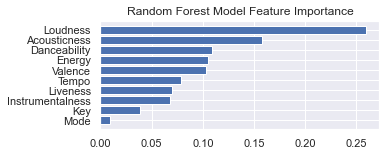

Random Forest Model tested with Top100 from year 2005
Out-of-bag score estimate: 0.812
Mean accuracy score: 0.745


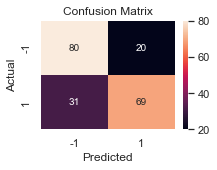

Random Forest Model tested with Top100 from year 2006
Out-of-bag score estimate: 0.815
Mean accuracy score: 0.81


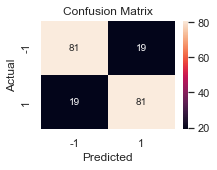

Random Forest Model tested with Top100 from year 2007
Out-of-bag score estimate: 0.809
Mean accuracy score: 0.835


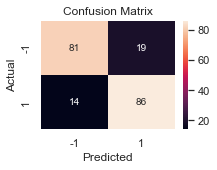

Random Forest Model tested with Top100 from year 2008
Out-of-bag score estimate: 0.812
Mean accuracy score: 0.82


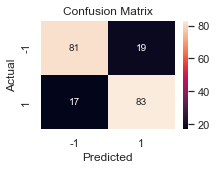

Random Forest Model tested with Top100 from year 2009
Out-of-bag score estimate: 0.809
Mean accuracy score: 0.835


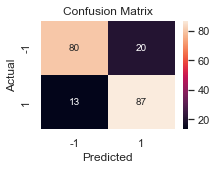

Random Forest Model tested with Top100 from year 2010
Out-of-bag score estimate: 0.815
Mean accuracy score: 0.825


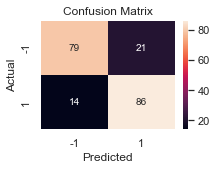

Random Forest Model tested with Top100 from year 2011
Out-of-bag score estimate: 0.811
Mean accuracy score: 0.855


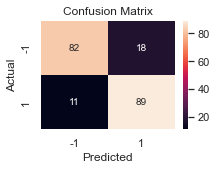

Random Forest Model tested with Top100 from year 2012
Out-of-bag score estimate: 0.809
Mean accuracy score: 0.825


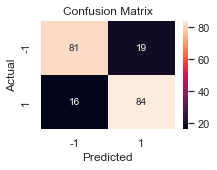

Random Forest Model tested with Top100 from year 2013
Out-of-bag score estimate: 0.815
Mean accuracy score: 0.82


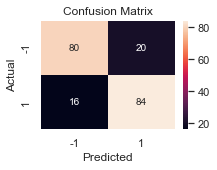

Random Forest Model tested with Top100 from year 2014
Out-of-bag score estimate: 0.806
Mean accuracy score: 0.865


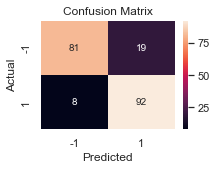

Random Forest Model tested with Top100 from year 2015
Out-of-bag score estimate: 0.804
Mean accuracy score: 0.855


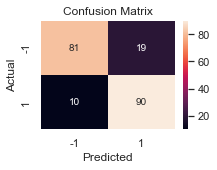

Random Forest Model tested with Top100 from year 2016
Out-of-bag score estimate: 0.811
Mean accuracy score: 0.83


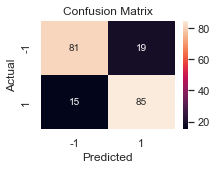

Random Forest Model tested with Top100 from year 2017
Out-of-bag score estimate: 0.809
Mean accuracy score: 0.87


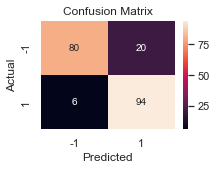

Random Forest Model tested with Top100 from year 2018
Out-of-bag score estimate: 0.804
Mean accuracy score: 0.84


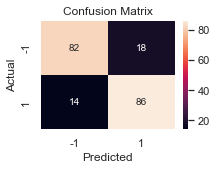

Random Forest Model tested with Top100 from year 2019
Out-of-bag score estimate: 0.809
Mean accuracy score: 0.86


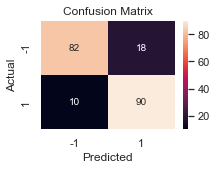

Random Forest Model tested with Top100 from year 2020
Out-of-bag score estimate: 0.814
Mean accuracy score: 0.82


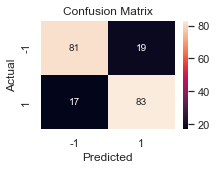

Random Forest Model tested with Top100 from year 2021
Out-of-bag score estimate: 0.807
Mean accuracy score: 0.84


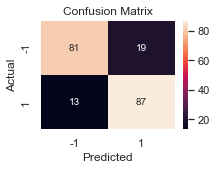

Random Forest Model tested with Top100 from year 2022
Out-of-bag score estimate: 0.81
Mean accuracy score: 0.805


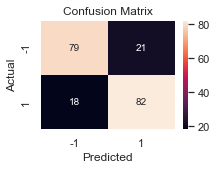

Summary of OOB score for each test year:
[0.8123529411764706, 0.8152941176470588, 0.8094117647058824, 0.8123529411764706, 0.8094117647058824, 0.8147058823529412, 0.8114705882352942, 0.8088235294117647, 0.8147058823529412, 0.8061764705882353, 0.8035294117647059, 0.8105882352941176, 0.8088235294117647, 0.8044117647058824, 0.8088235294117647, 0.8141176470588235, 0.8073529411764706, 0.81]
Average OOB score across all years:  0.8101307189542483

Summary of accuracy for each test year:
[0.745, 0.81, 0.835, 0.82, 0.835, 0.825, 0.855, 0.825, 0.82, 0.865, 0.855, 0.83, 0.87, 0.84, 0.86, 0.82, 0.84, 0.805]
Average accuracy across all years:  0.8308333333333332


In [55]:
#Display feature importance
featureimportanceRF(2023, 250, 16) #Use 2023 as testyear so that all data from 2005-2023 is used in training RF model

#Loop through the years, selecting a different test year each time (and excluding that data from the training set)
results_accuracy = []
results_oob_score_ = []
for i in range(2005, 2023):
    #Train the RF model and test with specified year and chosen parameters
    accuracy, oob_score_ = plotresultsRF(i, 250, 16)
    results_accuracy.append(accuracy)
    results_oob_score_.append(oob_score_)
    
print("Summary of OOB score for each test year:")
print(results_oob_score_)
print("Average OOB score across all years: ", sum(results_oob_score_)/len(results_oob_score_))
print("\nSummary of accuracy for each test year:")
print(results_accuracy)
print("Average accuracy across all years: ", sum(results_accuracy)/len(results_accuracy))

<a id='rf_loudness'></a>
## Random Forest Classifier model - trained on 'Loudness' feature only

In [56]:
def generatedatasetsLoudness(testyear):
    #create training and testing Top100 data, based on the year used for training
    dfcharttest = dfchart[dfchart['Year'] == testyear]
    dfcharttrain = dfchart[dfchart['Year'] != testyear]
    
    #combine Top100 and non-chart data training data
    dfcombined = pd.concat([dfcharttrain, dfnonchart])
    
    #Create the target data - the Top100 column. '1' for Top100 entry, and '-1' for a non-chart entry
    trainingtarget = dfcombined.loc[:,"Top100"]  
    testingtarget = dfcharttest.loc[:,"Top100"]

    #Identify the training and test data sets 
    X_train = dfcombined
    y_train = trainingtarget.values.tolist()

    #Testing set of 100 non-chart songs from 600k dataset (Top100 songs removed)
    X_noncharttest = dfnonchart100.copy()
    y_noncharttest = X_noncharttest.loc[:,"Top100"]

    #Combine the Top100 and non-chart testing data
    X_test = pd.concat([dfcharttest, X_noncharttest])
    y_test = pd.concat([testingtarget, y_noncharttest])
    y_test = y_test.values.tolist()
    
    #Data scaling is not necessary for Random Forest (tree-based, not distanced-based algorithm)
    
    #Choose data features to include in the training (all). This ensure only the feature columns are used in training
    X_trainF = X_train[['Loudness']]
    X_testF = X_test[['Loudness']]
    
    return X_train, X_test, X_trainF, X_testF, y_train, y_test
    
#Determine algorithm parameters for best accuracy (testing using 2022)
#Try to find best parameters for RandomForestClassifier
# https://www.datasciencelearner.com/how-to-improve-accuracy-of-random-forest-classifier/?utm_content=cmp-true
data = generatedatasetsLoudness(2022)
X_trainF = data[2]
y_train = data[4]

rf = RandomForestClassifier(random_state=123456)
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None] 
}

cv = GridSearchCV(rf,parameters,cv=5)
cv.fit(X_trainF, y_train)

print(f'Best parameters are: {cv.best_params_}')
print("\n")
mean_score = cv.cv_results_['mean_test_score']
std_score = cv.cv_results_['std_test_score']
params = cv.cv_results_['params']
for mean,std,params in zip(mean_score,std_score,params):
    print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

Best parameters are: {'max_depth': 2, 'n_estimators': 250}


0.738 + or -0.02 for the {'max_depth': 2, 'n_estimators': 5}
0.736 + or -0.02 for the {'max_depth': 2, 'n_estimators': 10}
0.739 + or -0.022 for the {'max_depth': 2, 'n_estimators': 50}
0.74 + or -0.021 for the {'max_depth': 2, 'n_estimators': 100}
0.74 + or -0.019 for the {'max_depth': 2, 'n_estimators': 250}
0.735 + or -0.021 for the {'max_depth': 4, 'n_estimators': 5}
0.736 + or -0.017 for the {'max_depth': 4, 'n_estimators': 10}
0.739 + or -0.022 for the {'max_depth': 4, 'n_estimators': 50}
0.737 + or -0.021 for the {'max_depth': 4, 'n_estimators': 100}
0.739 + or -0.02 for the {'max_depth': 4, 'n_estimators': 250}
0.722 + or -0.023 for the {'max_depth': 8, 'n_estimators': 5}
0.725 + or -0.026 for the {'max_depth': 8, 'n_estimators': 10}
0.731 + or -0.018 for the {'max_depth': 8, 'n_estimators': 50}
0.731 + or -0.019 for the {'max_depth': 8, 'n_estimators': 100}
0.731 + or -0.023 for the {'max_depth': 8, 'n_estimators': 2

In [57]:
def plotresultsRFLoudness(testyear, n_estimators, max_depth):
    data = generatedatasetsLoudness(testyear)
    X_trainF = data[2]
    X_testF = data[3]
    y_train = data[4]
    y_test = data[5]
    
    rf = trainRF(X_trainF, y_train, n_estimators, max_depth)

    #Determine accuracy score
    predicted = rf.predict(X_testF)
    accuracy = accuracy_score(y_test, predicted)
    print('Random Forest Model tested with Top100 from year', testyear)
    print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
    print(f'Mean accuracy score: {accuracy:.3}')

    fig = plt.figure(figsize=(3, 2)) 

    #Visualise the confusion matrix
    plt.title("Confusion Matrix")
    ax = pd.crosstab(y_test, predicted, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(ax, annot=True)
    plt.show()
    
    return accuracy, rf.oob_score_

def featureimportanceRFLoudness(testyear, n_estimators, max_depth):
    data = generatedatasetsLoudness(testyear)
    X_train = data[0]
    X_test = data[1]
    X_trainF = data[2] #only the audio feature columns
    X_testF = data[3]  #only the audio feature columns
    y_train = data[4]
    y_test = data[5]
    
    #Train the model
    rf = trainRF(X_trainF, y_train, n_estimators, max_depth)
    
    #Plot feature importance within the RF model
    fig = plt.figure(figsize=(5, 2))
    sorted_idx = rf.feature_importances_.argsort()
    ax = plt.barh(X_trainF.columns[sorted_idx], rf.feature_importances_[sorted_idx])
    plt.title("Random Forest Model Feature Importance")
    plt.show()

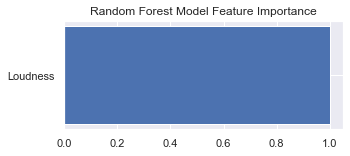

Random Forest Model tested with Top100 from year 2005
Out-of-bag score estimate: 0.737
Mean accuracy score: 0.78


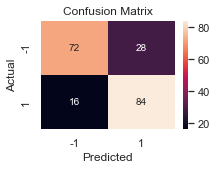

Random Forest Model tested with Top100 from year 2006
Out-of-bag score estimate: 0.738
Mean accuracy score: 0.775


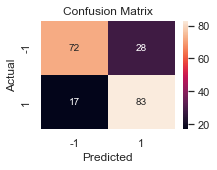

Random Forest Model tested with Top100 from year 2007
Out-of-bag score estimate: 0.736
Mean accuracy score: 0.785


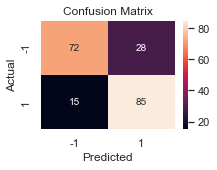

Random Forest Model tested with Top100 from year 2008
Out-of-bag score estimate: 0.736
Mean accuracy score: 0.805


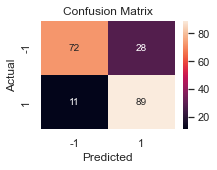

Random Forest Model tested with Top100 from year 2009
Out-of-bag score estimate: 0.734
Mean accuracy score: 0.81


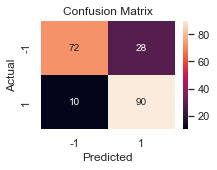

Random Forest Model tested with Top100 from year 2010
Out-of-bag score estimate: 0.737
Mean accuracy score: 0.775


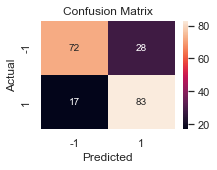

Random Forest Model tested with Top100 from year 2011
Out-of-bag score estimate: 0.736
Mean accuracy score: 0.785


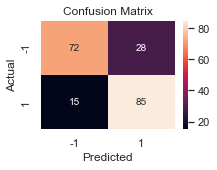

Random Forest Model tested with Top100 from year 2012
Out-of-bag score estimate: 0.732
Mean accuracy score: 0.8


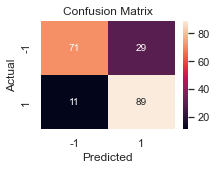

Random Forest Model tested with Top100 from year 2013
Out-of-bag score estimate: 0.738
Mean accuracy score: 0.77


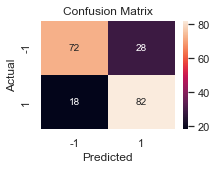

Random Forest Model tested with Top100 from year 2014
Out-of-bag score estimate: 0.736
Mean accuracy score: 0.8


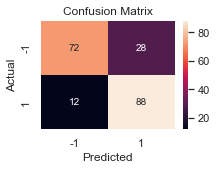

Random Forest Model tested with Top100 from year 2015
Out-of-bag score estimate: 0.738
Mean accuracy score: 0.78


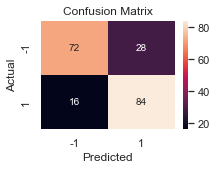

Random Forest Model tested with Top100 from year 2016
Out-of-bag score estimate: 0.736
Mean accuracy score: 0.775


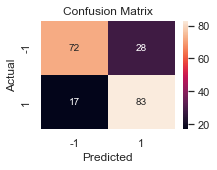

Random Forest Model tested with Top100 from year 2017
Out-of-bag score estimate: 0.736
Mean accuracy score: 0.8


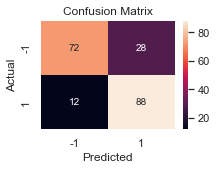

Random Forest Model tested with Top100 from year 2018
Out-of-bag score estimate: 0.737
Mean accuracy score: 0.77


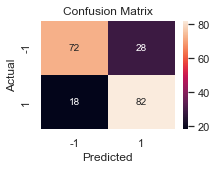

Random Forest Model tested with Top100 from year 2019
Out-of-bag score estimate: 0.737
Mean accuracy score: 0.785


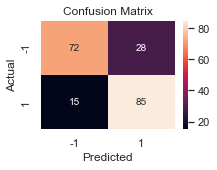

Random Forest Model tested with Top100 from year 2020
Out-of-bag score estimate: 0.739
Mean accuracy score: 0.745


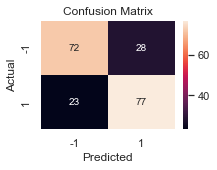

Random Forest Model tested with Top100 from year 2021
Out-of-bag score estimate: 0.738
Mean accuracy score: 0.76


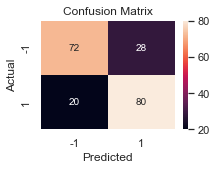

Random Forest Model tested with Top100 from year 2022
Out-of-bag score estimate: 0.739
Mean accuracy score: 0.755


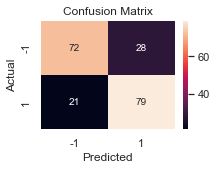

Summary of OOB score for each test year:
[0.7373529411764705, 0.7379411764705882, 0.7358823529411764, 0.7361764705882353, 0.7335294117647059, 0.7370588235294118, 0.7355882352941177, 0.731764705882353, 0.7376470588235294, 0.7358823529411764, 0.7382352941176471, 0.7358823529411764, 0.7358823529411764, 0.7373529411764705, 0.7370588235294118, 0.7385294117647059, 0.7382352941176471, 0.7385294117647059]
Average OOB score across all years:  0.7365849673202614

Summary of accuracy for each test year:
[0.78, 0.775, 0.785, 0.805, 0.81, 0.775, 0.785, 0.8, 0.77, 0.8, 0.78, 0.775, 0.8, 0.77, 0.785, 0.745, 0.76, 0.755]
Average accuracy across all years:  0.7808333333333334


In [58]:
#Display feature importance
featureimportanceRFLoudness(2023, 250, 2) #Use 2023 as testyear so that all data from 2005-2023 is used in training RF model

#Loop through the years, selecting a different test year each time (and excluding that data from the training set)
results_accuracy = []
results_oob_score_ = []
for i in range(2005, 2023):
    #Train the RF model and test with specified year and chosen parameters
    accuracy, oob_score_ = plotresultsRFLoudness(i, 250, 2)
    results_accuracy.append(accuracy)
    results_oob_score_.append(oob_score_)
    
print("Summary of OOB score for each test year:")
print(results_oob_score_)
print("Average OOB score across all years: ", sum(results_oob_score_)/len(results_oob_score_))
print("\nSummary of accuracy for each test year:")
print(results_accuracy)
print("Average accuracy across all years: ", sum(results_accuracy)/len(results_accuracy))


<a id='svm'></a>
## Support Vector Machine model - Linear kernel function

In [37]:
#Unlike Random Forect, SVM requires features to be scaled
def scalefeatures(X_trainF, X_testF):
    column_names = X_trainF.columns
    passthroughcolumns = []
    scalecolumns = ['Acousticness','Danceability','Energy','Instrumentalness','Liveness','Valence','Key','Mode','Tempo','Loudness']
    column_transformer = ColumnTransformer(transformers=[('pass', 'passthrough', passthroughcolumns),
                                                     ('scaler', MinMaxScaler(), scalecolumns)], remainder='passthrough')
    transformed_raw = column_transformer.fit_transform(X_trainF)
    X_trainF = pd.DataFrame(transformed_raw, columns=column_names)

    #Scale the test data using the same scaler as the training set 
    #(blindly apply it without recalculating mean/variance etc.)
    transformed_raw = column_transformer.fit_transform(X_testF)
    X_testF = pd.DataFrame(transformed_raw, columns=column_names)
    
    return X_trainF, X_testF

In [38]:
#Train (excl. test year) SVM model
def trainSVM(X_trainF, y_train, kernel):     
    # Instantiate the Support Vector Classifier (SVC)
    svc = SVC(C=1.0, random_state=123456, kernel=kernel)
 
    # Fit the model
    svc.fit(X_trainF, y_train)
    
    return svc

In [39]:
def plotresultsSVM(testyear, kernel):
    data = generatedatasets(testyear)
    X_train = data[0]
    X_test = data[1]
    X_trainF = data[2] #only the audio feature columns
    X_testF = data[3]  #only the audio feature columns
    y_train = data[4]
    y_test = data[5]
    
    #Scale features
    scaled = scalefeatures(X_trainF, X_testF)    
    X_trainF = scaled[0]
    X_testF = scaled[1]
    
    #Train the model
    svc = trainSVM(X_trainF, y_train, kernel)

    #Determine accuracy score
    predicted = svc.predict(X_testF)
    accuracy = accuracy_score(y_test, predicted)
    print('SVM Model tested with Top100 from year', testyear)
    print(f'Mean accuracy score: {accuracy:.5}')

    fig = plt.figure(figsize=(3, 2)) 
    
    #Visualise the confusion matrix
    #plt.figure(figsize=(4,3))
    plt.title("Confusion Matrix")
    ax = pd.crosstab(y_test, predicted, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(ax, annot=True)
    plt.show()
    
    return accuracy

In [40]:
def featureimportanceSVM(testyear):
    data = generatedatasets(testyear)
    X_train = data[0]
    X_test = data[1]
    X_trainF = data[2] #only the audio feature columns
    X_testF = data[3]  #only the audio feature columns
    y_train = data[4]
    y_test = data[5]
    
    #Scale features
    scaled = scalefeatures(X_trainF, X_testF)    
    X_trainF = scaled[0]
    
    #Train the model
    svc = trainSVM(X_trainF, y_train, 'linear') #Feature importance is only available for the linear kernel
    
    #Plot feature importance within the SVM model
    #https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
    fig = plt.figure(figsize=(5, 2)) 
    ax = pd.Series(abs(svc.coef_[0]), index=X_trainF.columns).nlargest(10).plot(kind='barh').invert_yaxis()
    plt.title("SVM Model Feature Importance")
    plt.show()


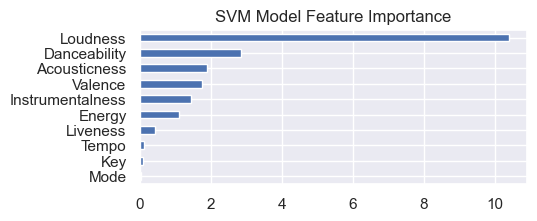

SVM Model tested with Top100 from year 2005
Mean accuracy score: 0.79


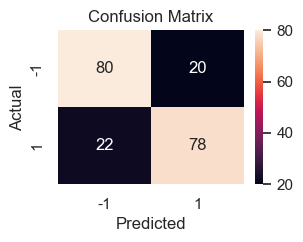

SVM Model tested with Top100 from year 2006
Mean accuracy score: 0.76


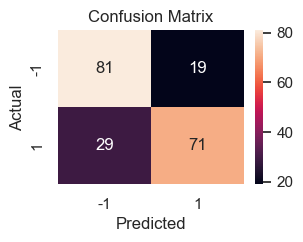

SVM Model tested with Top100 from year 2007
Mean accuracy score: 0.83


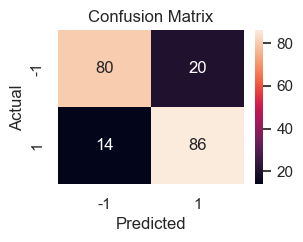

SVM Model tested with Top100 from year 2008
Mean accuracy score: 0.81


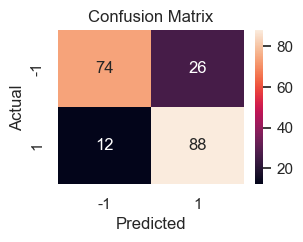

SVM Model tested with Top100 from year 2009
Mean accuracy score: 0.835


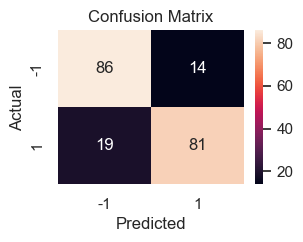

SVM Model tested with Top100 from year 2010
Mean accuracy score: 0.81


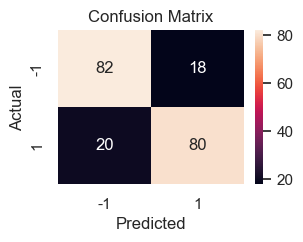

SVM Model tested with Top100 from year 2011
Mean accuracy score: 0.825


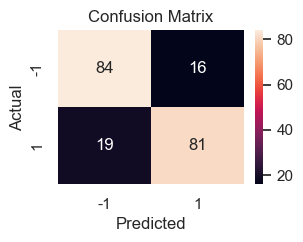

SVM Model tested with Top100 from year 2012
Mean accuracy score: 0.815


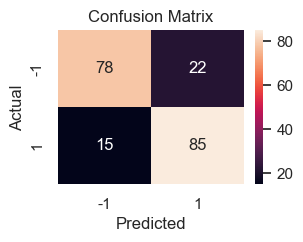

SVM Model tested with Top100 from year 2013
Mean accuracy score: 0.805


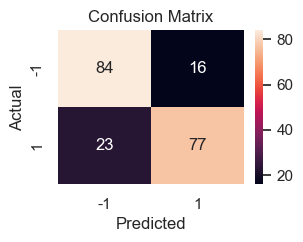

SVM Model tested with Top100 from year 2014
Mean accuracy score: 0.845


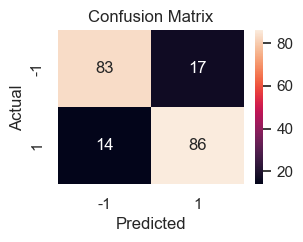

SVM Model tested with Top100 from year 2015
Mean accuracy score: 0.825


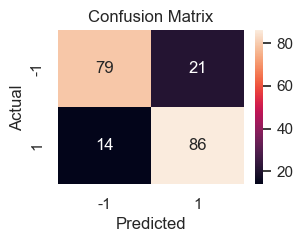

SVM Model tested with Top100 from year 2016
Mean accuracy score: 0.785


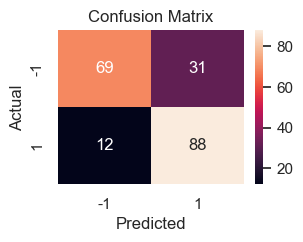

SVM Model tested with Top100 from year 2017
Mean accuracy score: 0.825


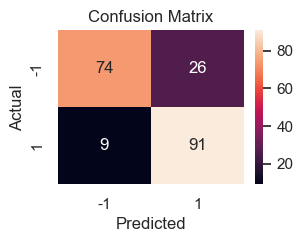

SVM Model tested with Top100 from year 2018
Mean accuracy score: 0.805


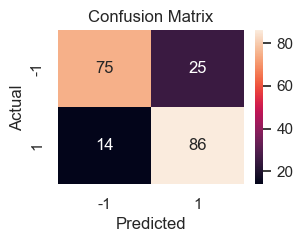

SVM Model tested with Top100 from year 2019
Mean accuracy score: 0.8


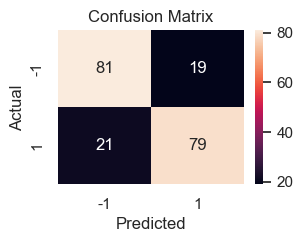

SVM Model tested with Top100 from year 2020
Mean accuracy score: 0.775


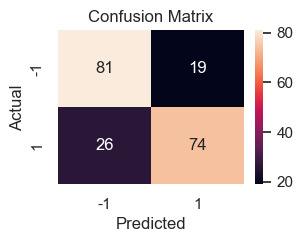

SVM Model tested with Top100 from year 2021
Mean accuracy score: 0.805


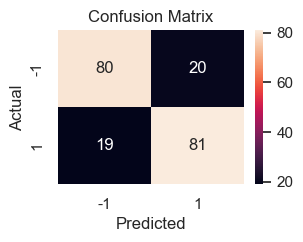

SVM Model tested with Top100 from year 2022
Mean accuracy score: 0.78


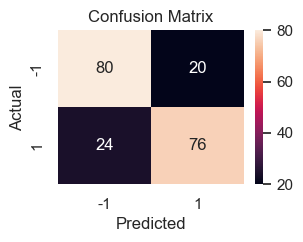

Summary of accuracy for each test year:
[0.79, 0.76, 0.83, 0.81, 0.835, 0.81, 0.825, 0.815, 0.805, 0.845, 0.825, 0.785, 0.825, 0.805, 0.8, 0.775, 0.805, 0.78]

Average accuracy across all years:  0.8069444444444445


In [41]:
#Display feature importance
featureimportanceSVM(2023) #Use 2023 as testyear so that all data from 2005-2023 is used in training SVM

results = []
for i in range(2005, 2023):
    #Train the SVM model and test with specified year
    accuracy = plotresultsSVM(i, 'linear')
    results.append(accuracy)
print("Summary of accuracy for each test year:")
print(results)
print("\nAverage accuracy across all years: ", sum(results)/len(results))

<a id='svm_rbf'></a>
### Support Vector Machine model - RBF kernel
The accuracy of the SVM model can be improved by using the RBF kernel intead of the linear kernel

SVM Model tested with Top100 from year 2005
Mean accuracy score: 0.8


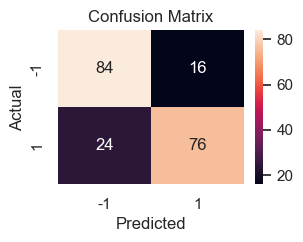

SVM Model tested with Top100 from year 2006
Mean accuracy score: 0.765


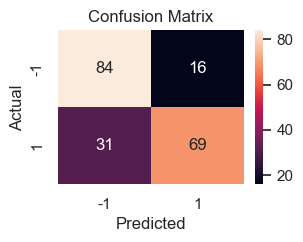

SVM Model tested with Top100 from year 2007
Mean accuracy score: 0.835


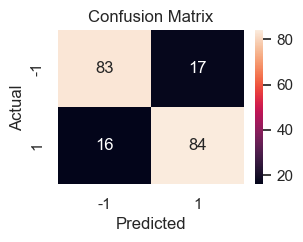

SVM Model tested with Top100 from year 2008
Mean accuracy score: 0.825


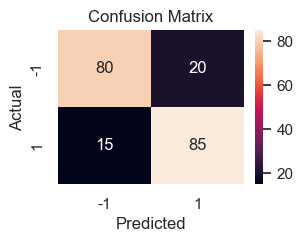

SVM Model tested with Top100 from year 2009
Mean accuracy score: 0.815


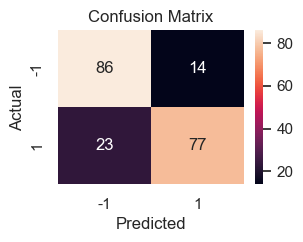

SVM Model tested with Top100 from year 2010
Mean accuracy score: 0.815


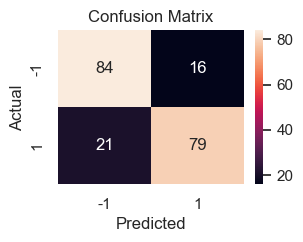

SVM Model tested with Top100 from year 2011
Mean accuracy score: 0.82


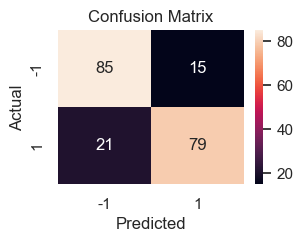

SVM Model tested with Top100 from year 2012
Mean accuracy score: 0.84


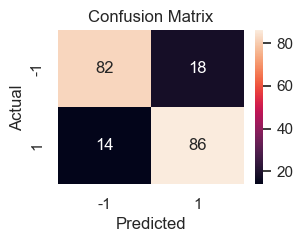

SVM Model tested with Top100 from year 2013
Mean accuracy score: 0.805


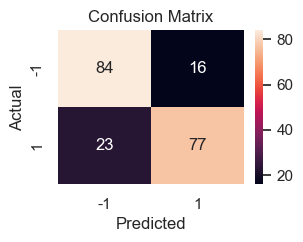

SVM Model tested with Top100 from year 2014
Mean accuracy score: 0.83


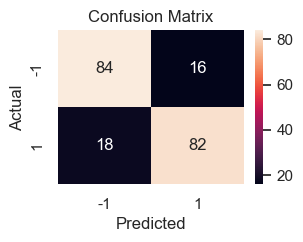

SVM Model tested with Top100 from year 2015
Mean accuracy score: 0.825


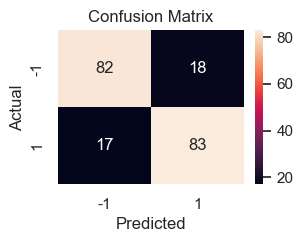

SVM Model tested with Top100 from year 2016
Mean accuracy score: 0.815


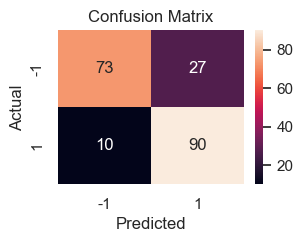

SVM Model tested with Top100 from year 2017
Mean accuracy score: 0.83


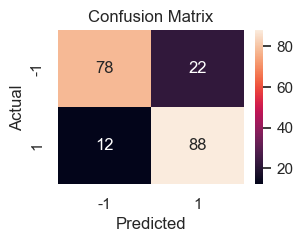

SVM Model tested with Top100 from year 2018
Mean accuracy score: 0.825


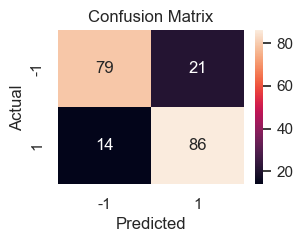

SVM Model tested with Top100 from year 2019
Mean accuracy score: 0.805


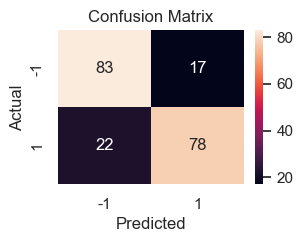

SVM Model tested with Top100 from year 2020
Mean accuracy score: 0.795


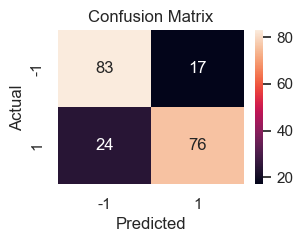

SVM Model tested with Top100 from year 2021
Mean accuracy score: 0.805


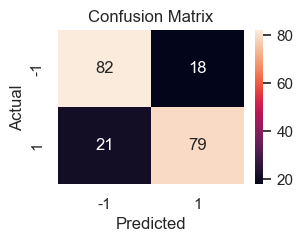

SVM Model tested with Top100 from year 2022
Mean accuracy score: 0.78


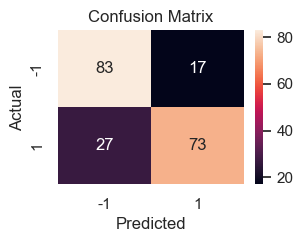

Summary of accuracy for each test year:
[0.8, 0.765, 0.835, 0.825, 0.815, 0.815, 0.82, 0.84, 0.805, 0.83, 0.825, 0.815, 0.83, 0.825, 0.805, 0.795, 0.805, 0.78]

Average accuracy across all years:  0.8127777777777775


In [42]:
results = []
for i in range(2005, 2023):
    #Train the SVM model and test with specified year
    accuracy = plotresultsSVM(i, 'rbf')
    results.append(accuracy)
print("Summary of accuracy for each test year:")
print(results)
print("\nAverage accuracy across all years: ", sum(results)/len(results))

<a id='svm_loudness'></a>
### SVM model - trained on 'Loudness' feature only (with linear kernel function)

In [44]:
def plotresultsSVMLoudness(testyear, kernel):
    data = generatedatasetsLoudness(testyear)
    X_train = data[0]
    X_test = data[1]
    X_trainF = data[2] #only the audio feature columns
    X_testF = data[3]  #only the audio feature columns
    y_train = data[4]
    y_test = data[5]
    
    #Scale features
    column_names = X_trainF.columns
    passthroughcolumns = []
    scalecolumns = ['Loudness']
    column_transformer = ColumnTransformer(transformers=[('pass', 'passthrough', passthroughcolumns),
                                                     ('scaler', MinMaxScaler(), scalecolumns)], remainder='passthrough')
    transformed_raw = column_transformer.fit_transform(X_trainF)
    X_trainF = pd.DataFrame(transformed_raw, columns=column_names)

    #Scale the test data using the same scaler as the training set 
    #(blindly apply it without recalculating mean/variance etc.)
    transformed_raw = column_transformer.fit_transform(X_testF)
    X_testF = pd.DataFrame(transformed_raw, columns=column_names)
    
    
    #Train the model
    svc = trainSVM(X_trainF, y_train, kernel)

    #Determine accuracy score
    predicted = svc.predict(X_testF)
    accuracy = accuracy_score(y_test, predicted)
    print('SVM Model (\'loudness\' feature) tested with Top100 from year', testyear)
    print(f'Mean accuracy score: {accuracy:.5}')

    fig = plt.figure(figsize=(3, 2)) 
    
    #Visualise the confusion matrix
    #plt.figure(figsize=(4,3))
    plt.title("Confusion Matrix")
    ax = pd.crosstab(y_test, predicted, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(ax, annot=True)
    plt.show()
    
    return accuracy

SVM Model ('loudness' feature) tested with Top100 from year 2005
Mean accuracy score: 0.775


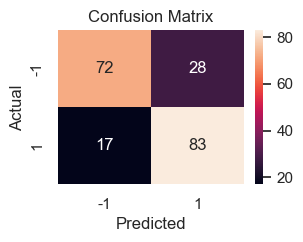

SVM Model ('loudness' feature) tested with Top100 from year 2006
Mean accuracy score: 0.77


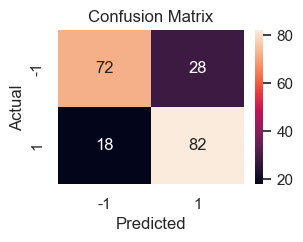

SVM Model ('loudness' feature) tested with Top100 from year 2007
Mean accuracy score: 0.78


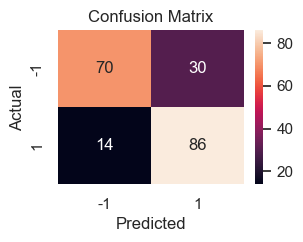

SVM Model ('loudness' feature) tested with Top100 from year 2008
Mean accuracy score: 0.81


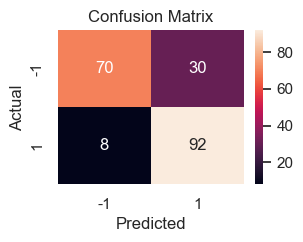

SVM Model ('loudness' feature) tested with Top100 from year 2009
Mean accuracy score: 0.79


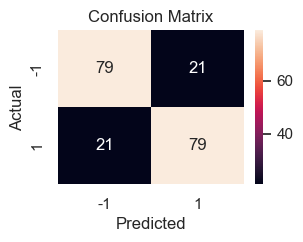

SVM Model ('loudness' feature) tested with Top100 from year 2010
Mean accuracy score: 0.77


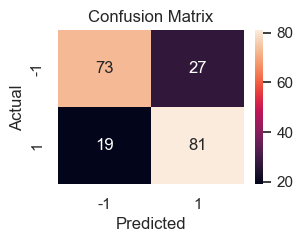

SVM Model ('loudness' feature) tested with Top100 from year 2011
Mean accuracy score: 0.775


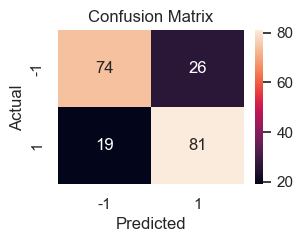

SVM Model ('loudness' feature) tested with Top100 from year 2012
Mean accuracy score: 0.805


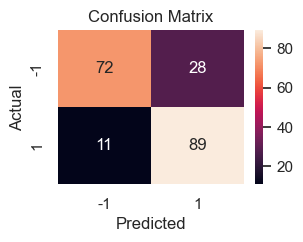

SVM Model ('loudness' feature) tested with Top100 from year 2013
Mean accuracy score: 0.735


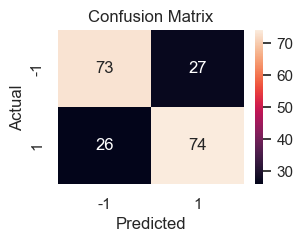

SVM Model ('loudness' feature) tested with Top100 from year 2014
Mean accuracy score: 0.765


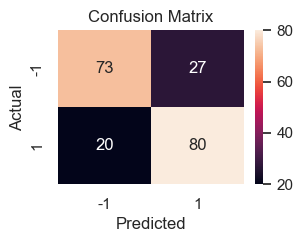

SVM Model ('loudness' feature) tested with Top100 from year 2015
Mean accuracy score: 0.78


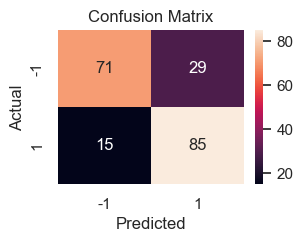

SVM Model ('loudness' feature) tested with Top100 from year 2016
Mean accuracy score: 0.765


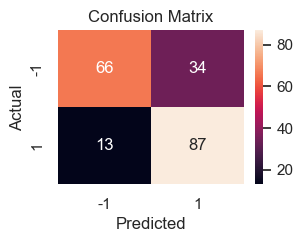

SVM Model ('loudness' feature) tested with Top100 from year 2017
Mean accuracy score: 0.8


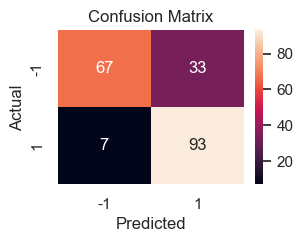

SVM Model ('loudness' feature) tested with Top100 from year 2018
Mean accuracy score: 0.765


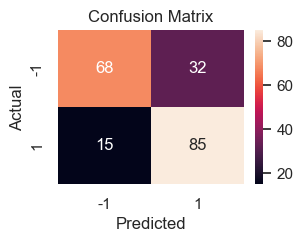

SVM Model ('loudness' feature) tested with Top100 from year 2019
Mean accuracy score: 0.77


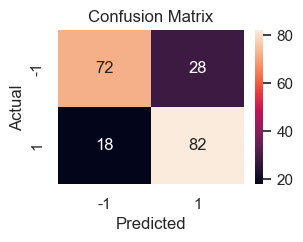

SVM Model ('loudness' feature) tested with Top100 from year 2020
Mean accuracy score: 0.73


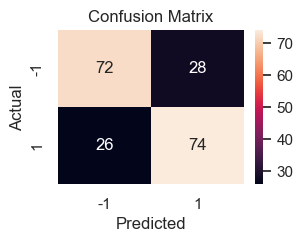

SVM Model ('loudness' feature) tested with Top100 from year 2021
Mean accuracy score: 0.745


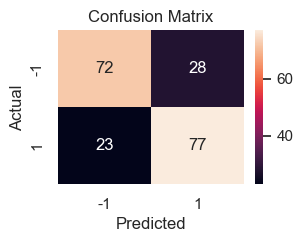

SVM Model ('loudness' feature) tested with Top100 from year 2022
Mean accuracy score: 0.745


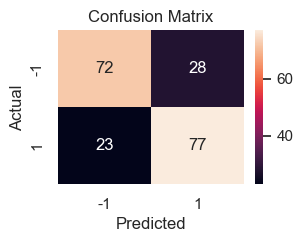

Summary of accuracy for each test year:
[0.775, 0.77, 0.78, 0.81, 0.79, 0.77, 0.775, 0.805, 0.735, 0.765, 0.78, 0.765, 0.8, 0.765, 0.77, 0.73, 0.745, 0.745]

Average accuracy across all years:  0.7708333333333334


In [45]:
results = []
for i in range(2005, 2023):
    #Train the SVM model and test with specified year
    accuracy = plotresultsSVMLoudness(i, 'linear')
    results.append(accuracy)
print("Summary of accuracy for each test year:")
print(results)
print("\nAverage accuracy across all years: ", sum(results)/len(results))